In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayshah1234","key":"b5a70f58d9814ed536fb83b549b26d2c"}'}

In [2]:
# Move the uploaded kaggle.json file to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d prajitdatta/movielens-100k-dataset

100% 4.77M/4.77M [00:00<00:00, 27.2MB/s]
100% 4.77M/4.77M [00:00<00:00, 27.1MB/s]


In [4]:
# Unzip the downloaded dataset
!unzip movielens-100k-dataset.zip

Archive:  movielens-100k-dataset.zip
  inflating: ml-100k/README          
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [5]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# Read users data

In [6]:
user_columns = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users_df = pd.read_csv('/content/ml-100k/u.user', sep='|', names=user_columns)
users_df.head(2)

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043


# Read movies data

In [7]:
genre_df = pd.read_csv('/content/ml-100k/u.genre', sep='|', encoding='latin-1')
genre_columns = ["unknown"] + list(genre_df[genre_df.columns[0]].values)
print(genre_columns)

['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [8]:
movie_columns = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies_df = pd.read_csv('/content/ml-100k/u.item', sep='|', names=movie_columns+genre_columns,
                     encoding='latin-1')

In [9]:
movies_df.head(2)

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


Because we are not building now a content-based recommender, we retain only movie_id and title.

In [10]:
movies_df = movies_df[["movie_id", "title"]]
movies_df.head(2)

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


# Read ratings data

In [11]:
ratings_columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings_df = pd.read_csv('/content/ml-100k/u.data', sep='\t', names=ratings_columns)
ratings_df.drop( "unix_timestamp", inplace = True, axis = 1 )
ratings_df.head(2)

,user_id,movie_id,rating
0,196,242,3
1,186,302,3


We merge now ratings with movie data.

[What is Joins and why used Outer?](https://chat.openai.com/share/35561c14-16ec-43db-8bcc-a283c2adc2a6)

An outer join combines rows from both DataFrames where the join condition is met, and includes all rows from both DataFrames even if the join condition is not met. This means that if there are rows in ratings_df that do not have corresponding entries in movies_df, or vice versa, those rows will still be included in the resulting DataFrame (rating_movies_df), with missing values filled in where there are no matches.

In [12]:
rating_movies_df = ratings_df.merge(movies_df, how="outer")

In [13]:
print(rating_movies_df.shape)
rating_movies_df.head(2)

(100000, 4)


,user_id,movie_id,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)


In [14]:
movie_rating = rating_movies_df.dropna(axis = 0, subset = ["title"])
movie_rating_count = movie_rating.groupby(["title"])["rating"].count().reset_index().rename(columns = {'rating': 'total_rating_count'})
movie_rating_count.head()

,title,total_rating_count
0,'Til There Was You (1997),9
1,1-900 (1994),5
2,101 Dalmatians (1996),109
3,12 Angry Men (1957),125
4,187 (1997),41


# Merge total rating count to the movie ratings

In [15]:
rating_movies_df = rating_movies_df.merge(movie_rating_count, on="title", how="right")

In [16]:
rating_movies_df.head()

,user_id,movie_id,rating,title,total_rating_count
0,223,1300,1,'Til There Was You (1997),9
1,178,1300,3,'Til There Was You (1997),9
2,342,1300,1,'Til There Was You (1997),9
3,530,1300,2,'Til There Was You (1997),9
4,416,1300,3,'Til There Was You (1997),9


In [17]:
rating_movies_df.total_rating_count.describe()

count    100000.000000
mean        169.088380
std         122.187866
min           1.000000
25%          72.000000
50%         146.000000
75%         240.000000
max         583.000000
Name: total_rating_count, dtype: float64

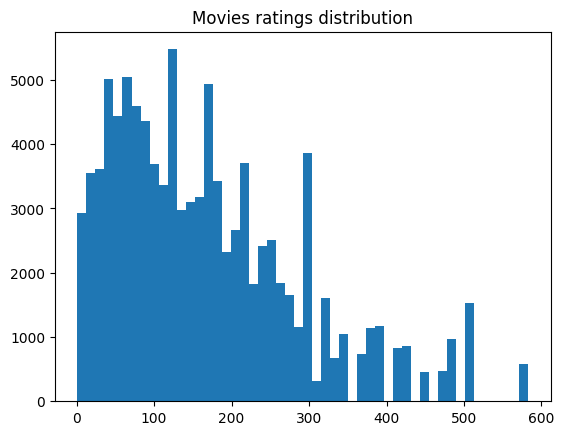

In [18]:
import matplotlib.pyplot as plt
plt.hist(rating_movies_df.total_rating_count, bins=50)
plt.title("Movies ratings distribution")
plt.show()

In [19]:
ratings_threshold = 100
rating_popular_movies_df = rating_movies_df.loc[rating_movies_df.total_rating_count >= ratings_threshold]
print(rating_popular_movies_df.shape)
rating_popular_movies_df.head()

(65008, 5)


,user_id,movie_id,rating,title,total_rating_count
14,5,225,2,101 Dalmatians (1996),109
15,243,225,3,101 Dalmatians (1996),109
16,200,225,4,101 Dalmatians (1996),109
17,280,225,4,101 Dalmatians (1996),109
18,1,225,2,101 Dalmatians (1996),109


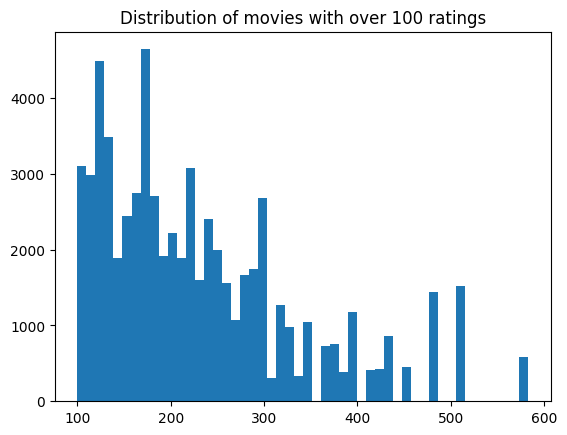

In [20]:
plt.hist(rating_popular_movies_df.total_rating_count, bins=50)
plt.title("Distribution of movies with over 100 ratings")
plt.show()

In [21]:
user_features_df = rating_popular_movies_df.pivot_table(index="user_id", columns="title", values="rating").fillna(0.0)

We create a sparse matrix from the original dataframe. This will allow the following operations to be performed on a sparse matrix, i.e. faster (only non-zero values are included).

In [22]:
user_features_matrix = csr_matrix(user_features_df)

In [23]:
model_knn = NearestNeighbors(metric = "cosine", algorithm = "brute", n_neighbors = 20, n_jobs=-1)
model_knn.fit(user_features_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [24]:
user_features_df.shape

(943, 338)

In [25]:
user_features_df.head()

title,101 Dalmatians (1996),12 Angry Men (1957),2001: A Space Odyssey (1968),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),"Adventures of Priscilla, Queen of the Desert, The (1994)","African Queen, The (1951)",Air Force One (1997),Aladdin (1992),...,Welcome to the Dollhouse (1995),What's Eating Gilbert Grape (1993),When Harry Met Sally... (1989),While You Were Sleeping (1995),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wrong Trousers, The (1993)",Young Frankenstein (1974),Young Guns (1988)
user_id,,,,,,,,,,,,,,,,,,,,,
1,2.0,5.0,4.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0,...,5.0,4.0,5.0,4.0,0.0,4.0,4.0,5.0,5.0,3.0
2,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,0.0,0.0,1.0,1.0,1.0,3.0,0.0,5.0,4.0,0.0


# Test the recommendation

In [26]:
query_index = np.random.choice(user_features_df.shape[0])
print(query_index)

488


Use the model fit to get the closest movies

In [31]:
distances, indices = model_knn.kneighbors(user_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [32]:
user_ids = []
for index in range(0, len(distances.flatten())):
    user_ids.append(user_features_df.index[indices.flatten()[index]])
    if index == 0: # the movie chosen
        print(f"Users similar with user having user_id:  {user_features_df.index[query_index]}")
        print("---------------------------------------------------------")
    else:
        print(f"{index}: {user_features_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

Users similar with user having user_id:  489
---------------------------------------------------------
1: 587 (dist: 0.10739805550683468)
2: 863 (dist: 0.15756391439919193)
3: 782 (dist: 0.18154744508771137)
4: 616 (dist: 0.189824735642958)
5: 112 (dist: 0.2233287943380411)


In [33]:
print(user_ids)

[489, 587, 863, 782, 616, 112]


These users are similar to the current user selected. For this user, we will recommend movies that were ranked by the users similar to him.

In [34]:
# select movies that were highly ranked by the most similar users.

# look only for movies highly rated by the similar users, not the current user
candidate_user_ids = user_ids[1:]
sel_ratings = rating_popular_movies_df.loc[rating_popular_movies_df.user_id.isin(candidate_user_ids)]

# sort by best ratings and total rating count
sel_ratings = sel_ratings.sort_values(by=["rating", "total_rating_count"], ascending=False)

# eliminate from the selection movies that were ranked already by the current user
movies_rated_by_targeted_user = list(rating_popular_movies_df.loc[rating_popular_movies_df.user_id==user_ids[0]]["movie_id"].values)
sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]

# aggregate and count total ratings and total total_rating_count
agg_sel_ratings = sel_ratings.groupby(["title", "rating"])["total_rating_count"].max().reset_index()
agg_sel_ratings.columns = ["title", "rating", "total_ratings"]
agg_sel_ratings = agg_sel_ratings.sort_values(by=["rating", "total_ratings"], ascending=False)

# only select top n (default top 10 here)
rec_list = agg_sel_ratings["title"].head(10).values
print(f"\nMovies recommended to user: {indices[0][0]}\n---------------------------------")
for i, rec in enumerate(rec_list):
    print(f"{i+1}: {rec}")


Movies recommended to user: 488
---------------------------------
1: Godfather, The (1972)
2: Fifth Element, The (1997)
3: Face/Off (1997)
4: My Best Friend's Wedding (1997)
5: Grosse Pointe Blank (1997)
6: Seven Years in Tibet (1997)
7: Kolya (1996)
8: Ice Storm, The (1997)
9: Star Wars (1977)
10: Return of the Jedi (1983)


Let's pack this in a recommendation function.

In [35]:
def recommend(user_id=10, n_users=5, rec_top_n=10):

    distances, indices = model_knn.kneighbors(user_features_df.loc[user_features_df.index==user_id].values.reshape(1, -1), n_neighbors = n_users + 1)
    user_ids = []
    for index in range(0, len(distances.flatten())):
        user_ids.append(user_features_df.index[indices.flatten()[index]])
        if index == 0: # the movie chosen
            print(f"Users similar with user having user_id: {user_id}")
            print("---------------------------------------------------------")
        else:
            print(f"{index}: {user_features_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

    # select movies that were highly ranked by the most similar users.

    # look only for movies highly rated by the similar users, not the current user
    candidate_user_ids = user_ids[1:]
    sel_ratings = rating_popular_movies_df.loc[rating_popular_movies_df.user_id.isin(candidate_user_ids)]
    # sort by best ratings and total rating count
    sel_ratings = sel_ratings.sort_values(by=["rating", "total_rating_count"], ascending=False)
    # eliminate from the selection movies that were ranked already by the current user
    movies_rated_by_targeted_user = list(rating_popular_movies_df.loc[rating_popular_movies_df.user_id==user_ids[0]]["movie_id"].values)
    sel_ratings = sel_ratings.loc[~sel_ratings.movie_id.isin(movies_rated_by_targeted_user)]
    # aggregate and count total ratings and total total_rating_count
    agg_sel_ratings = sel_ratings.groupby(["title", "rating"])["total_rating_count"].max().reset_index()
    agg_sel_ratings.columns = ["title", "rating", "total_ratings"]
    agg_sel_ratings = agg_sel_ratings.sort_values(by=["rating", "total_ratings"], ascending=False)
    # only select top n (default top 10 here)
    rec_list = agg_sel_ratings["title"].head(10).values
    print(f"\nMovies recommended to user_id: {user_ids[0]}\n---------------------------------")
    for i, rec in enumerate(rec_list):
        print(f"{i+1}: {rec}")

In [36]:
recommend(10, 5, 10)

Users similar with user having user_id: 10
---------------------------------------------------------
1: 234 (dist: 0.30522357013499)
2: 537 (dist: 0.33258977483692387)
3: 666 (dist: 0.3429645099419919)
4: 308 (dist: 0.3456794405474881)
5: 561 (dist: 0.3474196329895026)

Movies recommended to user_id: 10
---------------------------------
1: E.T. the Extra-Terrestrial (1982)
2: Schindler's List (1993)
3: Groundhog Day (1993)
4: Blade Runner (1982)
5: Speed (1994)
6: Babe (1995)
7: Godfather: Part II, The (1974)
8: Boot, Das (1981)
9: Face/Off (1997)
10: Heathers (1989)


In [37]:
recommend(42, 6, 10)

Users similar with user having user_id: 42
---------------------------------------------------------
1: 577 (dist: 0.33270711432283506)
2: 311 (dist: 0.3328110075576892)
3: 864 (dist: 0.35151818983622174)
4: 378 (dist: 0.35259834797545886)
5: 301 (dist: 0.3540984845746826)
6: 290 (dist: 0.3551903173524096)

Movies recommended to user_id: 42
---------------------------------
1: Contact (1997)
2: Fargo (1996)
3: English Patient, The (1996)
4: Scream (1996)
5: Pulp Fiction (1994)
6: Twelve Monkeys (1995)
7: Rock, The (1996)
8: Titanic (1997)
9: Full Monty, The (1997)
10: Dead Man Walking (1995)
